# 1. Importing Libraries & Data
In this section, we set up the foundation for our project by importing the necessary Python libraries and loading the dataset. These libraries provide the tools for data manipulation, visualization, and machine learning modeling throughout the notebook. Additionally, we import the historical claims dataset, which forms the core of our analysis. 

In [65]:
import pandas as pd
import numpy as np

# Train-Test Split
from sklearn.model_selection import train_test_split

import preproc as p

pd.set_option('display.max_columns', None)
# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

**Import Data**

In [66]:
# Load training data
df = pd.read_csv('./project_data/train_data_EDA.csv', index_col = 'Claim Identifier')

# Load testing data
test = pd.read_csv('./project_data/test_data_EDA.csv', index_col = 'Claim Identifier')

# Display the first 3 rows of the training data
df.head(3)

Age at Injury  Average Weekly Wage  Birth Year  \
Claim Identifier                                                   
5393875                    31.0                 0.00      1988.0   
5393091                    46.0              1745.93      1973.0   
5393889                    40.0              1434.80      1979.0   

                  Claim Injury Type  IME-4 Count  Industry Code  \
Claim Identifier                                                  
5393875                           1          0.0           44.0   
5393091                           3          4.0           23.0   
5393889                           3          0.0           56.0   

                  WCIO Cause of Injury Code  WCIO Nature of Injury Code  \
Claim Identifier                                                          
5393875                                  27                          10   
5393091                                  97                          49   
5393889                                  79                           7   

                  WCIO Part Of Body Code  Number of Dependents  \
Claim Identifier                                                 
5393875                               62                   1.0   
5393091                               38                   4.0   
5393889                               10                   6.0   

                  Alternative Dispute Resolution Bin  \
Claim Identifier                                       
5393875                                            0   
5393091                                            0   
5393889                                            0   

                  Attorney/Representative Bin  Carrier Name Enc  \
Claim Identifier                                                  
5393875                                     0              1015   
5393091                                     1               640   
5393889                                     0               710   

                  Carrier Type freq  Carrier Type_1A. PRIVATE  \
Claim Identifier                                                
5393875                      273422                         1   
5393091                      273422                         1   
5393889                      273422                         1   

                  Carrier Type_2A. SIF  Carrier Type_3A. SELF PUBLIC  \
Claim Identifier                                                       
5393875                              0                             0   
5393091                              0                             0   
5393889                              0                             0   

                  Carrier Type_4A. SELF PRIVATE  County of Injury freq  \
Claim Identifier                                                         
5393875                                       0                   3124   
5393091                                       0                    691   
5393889                                       0                  16883   

                  COVID-19 Indicator Enc  District Name freq  Gender Enc  \
Claim Identifier                                                           
5393875                                0               43001           0   
5393091                                0               39019           1   
5393889                                0               82516           0   

                  Gender_F  Gender_M  Medical Fee Region freq  \
Claim Identifier                                                
5393875                  0         1                   130727   
5393091                  1         0                   130727   
5393889                  0         1                    84173   

                  Accident Date Year  Accident Date Month  Accident Date Day  \
Claim Identifier                                                               
5393875                         2019                   12                 30   
5393091     

# 2. Train-Test Split
The train-test split is a crucial technique used to assess model performance by dividing the dataset into training and testing subsets. This ensures that the model is evaluated on unseen data, helping to prevent overfitting and providing an unbiased performance estimate. 

<a href="#top">Top &#129033;</a>

**Holdout Method**

In [67]:
# Split the DataFrame into features (X) and target variable (y)
X = df.drop('Claim Injury Type', axis=1) 
y = df['Claim Injury Type']  

In [68]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify = y) 


# 3. Missing Values

In [69]:
X_train.isna().sum()

Age at Injury                             0
Average Weekly Wage                   22186
Birth Year                            23322
IME-4 Count                               0
Industry Code                             0
WCIO Cause of Injury Code                 0
WCIO Nature of Injury Code                0
WCIO Part Of Body Code                    0
Number of Dependents                      0
Alternative Dispute Resolution Bin        0
Attorney/Representative Bin               0
Carrier Name Enc                          0
Carrier Type freq                         0
Carrier Type_1A. PRIVATE                  0
Carrier Type_2A. SIF                      0
Carrier Type_3A. SELF PUBLIC              0
Carrier Type_4A. SELF PRIVATE             0
County of Injury freq                     0
COVID-19 Indicator Enc                    0
District Name freq                        0
Gender Enc                                0
Gender_F                                  0
Gender_M                        

**Birth Year**

To fill the missing values, we will start by creating a mask, which filters for observations where **Age at Injury** and **Accident Date Year** are not missing, and when **Birth Year** is either missing or zero. Since we are going to use **Age at Injury** and **Accident Date Year** to compute **Birth Year**, ensuring those two variables are no missing is crucial. Then, we also decided to recompute the **Birth Year** where it is 0, since it is impossible to have 0 as a **Birth Year**.

In [70]:
train_mask = X_train['Accident Date Year'].notna() & X_train['Age at Injury'].notna() & \
           (X_train['Birth Year'].isna() | (X_train['Birth Year'] == 0))


val_mask = (X_val['Accident Date Year'].notna() &  X_val['Age at Injury'].notna() &  
    (X_val['Birth Year'].isna() | (X_val['Birth Year'] == 0)))

test_mask = test['Accident Date Year'].notna() & test['Age at Injury'].notna() & \
           (test['Birth Year'].isna() | (test['Birth Year'] == 0))

In [71]:
X_train.loc[train_mask, 'Birth Year'] = X_train['Accident Date Year'] - X_train['Age at Injury']

X_val.loc[val_mask, 'Birth Year'] = X_val['Accident Date Year'] - X_val['Age at Injury']

test.loc[test_mask, 'Birth Year'] = test['Accident Date Year'] - test['Age at Injury']

**Average Weekly Wage**

In [72]:
X_train['Average Weekly Wage'] = p.ball_tree_impute(X_train, 'Average Weekly Wage', n_neighbors=100)

X_val['Average Weekly Wage'] = p.ball_tree_impute(X_val, 'Average Weekly Wage', n_neighbors=100)

test['Average Weekly Wage'] = p.ball_tree_impute(test, 'Average Weekly Wage', n_neighbors=100)

# 3. Outliers

### Outlier Detection

To detect outliers we will use a function that plots boxplots and identifies outliers based on the Interquartile Range method. This function will also add to a list all columns with a higher percentage of outliers than a previously set threshold.

Column: Age at Injury - Number of Outliers: 0
Column: Age at Injury - % of Outliers: 0.00% 



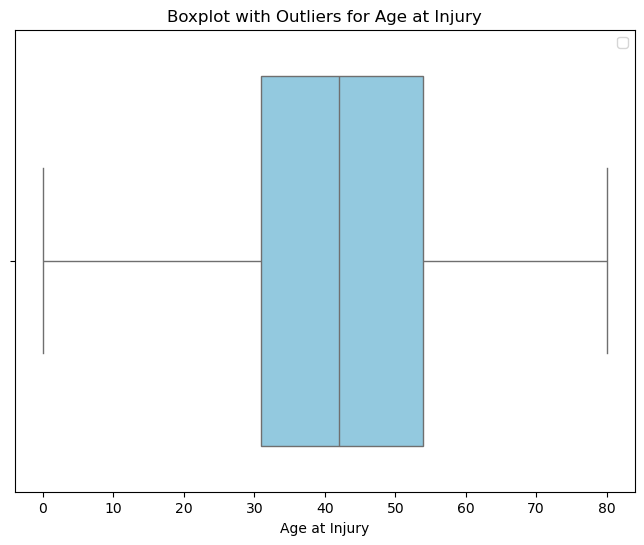

Column: Average Weekly Wage - Number of Outliers: 18431
Column: Average Weekly Wage - % of Outliers: 4.16% 



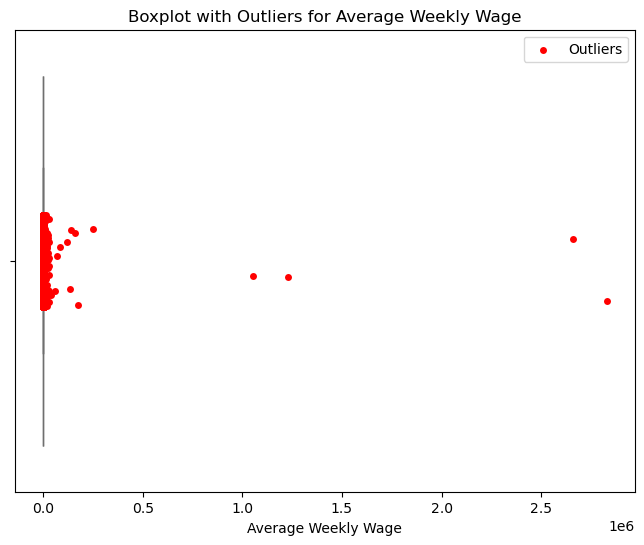

Column: Birth Year - Number of Outliers: 103
Column: Birth Year - % of Outliers: 0.02% 



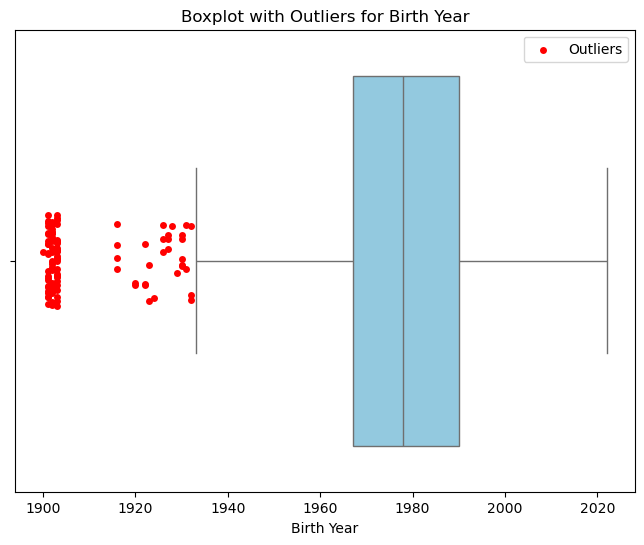

Column: IME-4 Count - Number of Outliers: 103518
Column: IME-4 Count - % of Outliers: 23.37% 



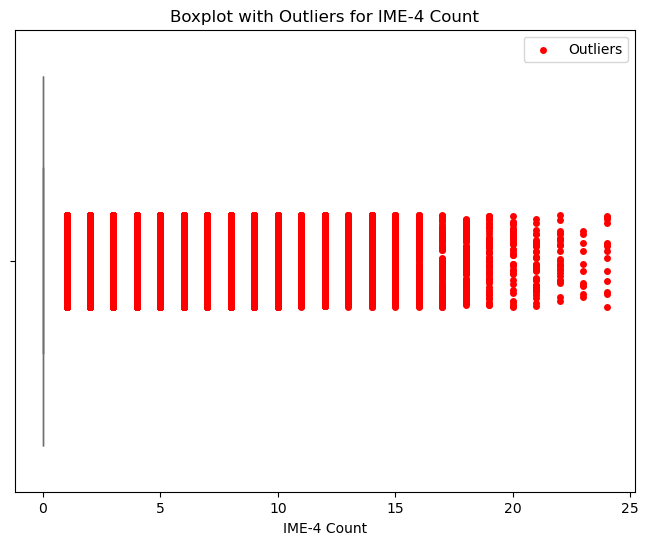

Column: Industry Code - Number of Outliers: 81447
Column: Industry Code - % of Outliers: 18.39% 



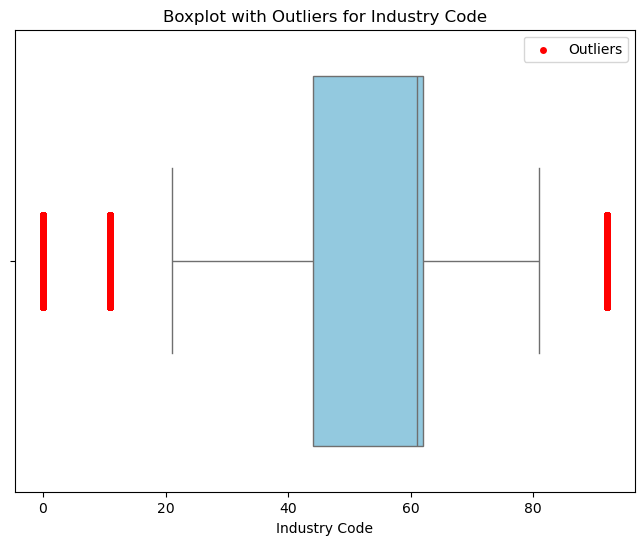

Column: WCIO Cause of Injury Code - Number of Outliers: 0
Column: WCIO Cause of Injury Code - % of Outliers: 0.00% 



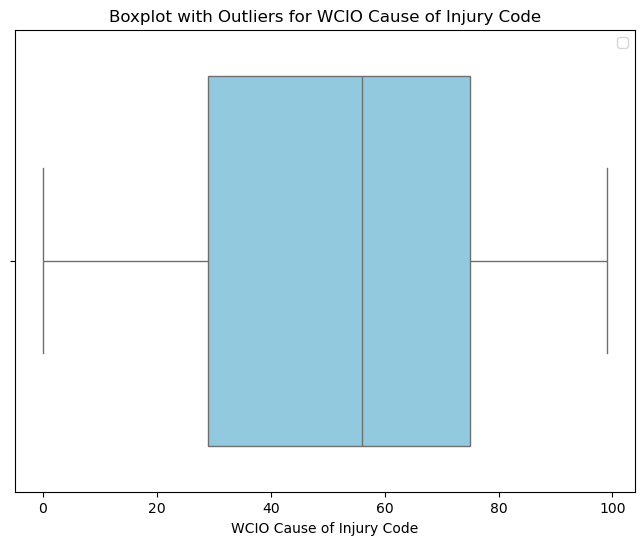

Column: WCIO Nature of Injury Code - Number of Outliers: 0
Column: WCIO Nature of Injury Code - % of Outliers: 0.00% 



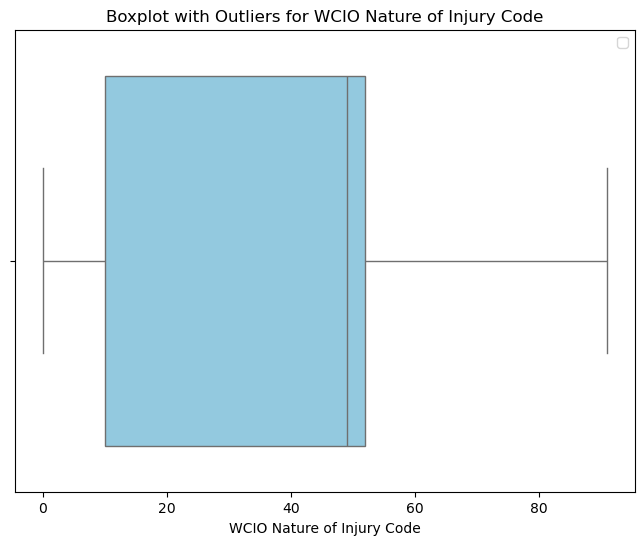

Column: WCIO Part Of Body Code - Number of Outliers: 39298
Column: WCIO Part Of Body Code - % of Outliers: 8.87% 



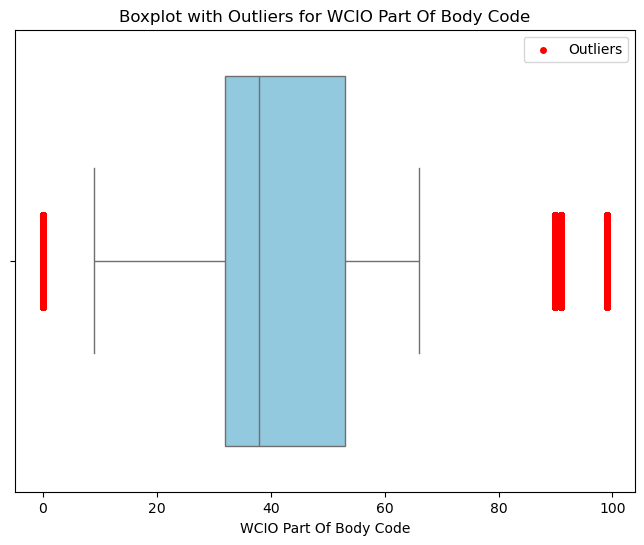

Column: Number of Dependents - Number of Outliers: 0
Column: Number of Dependents - % of Outliers: 0.00% 



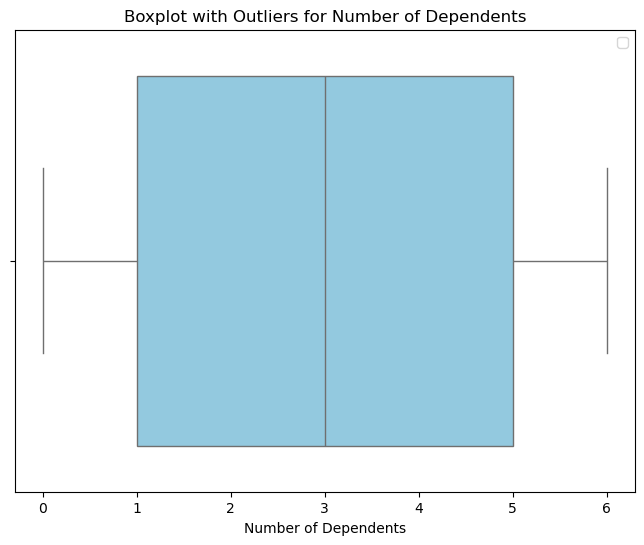

Column: Alternative Dispute Resolution Bin - Number of Outliers: 1945
Column: Alternative Dispute Resolution Bin - % of Outliers: 0.44% 



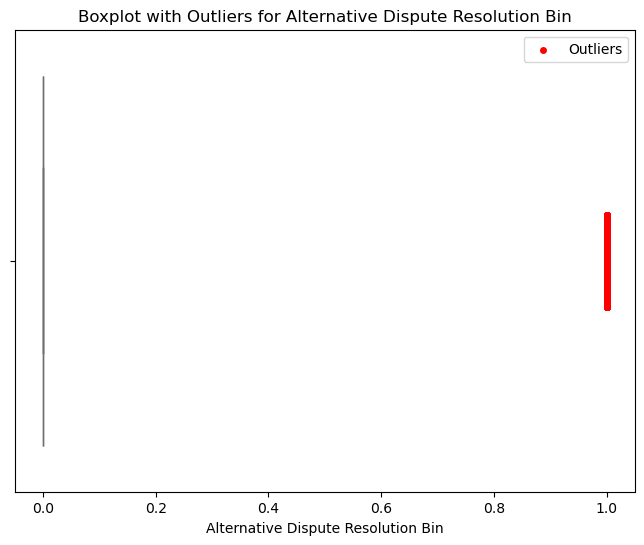

Column: Attorney/Representative Bin - Number of Outliers: 0
Column: Attorney/Representative Bin - % of Outliers: 0.00% 



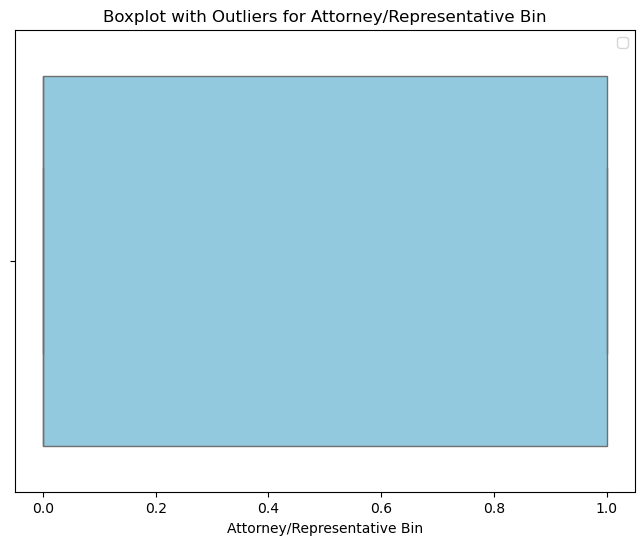

Column: Carrier Name Enc - Number of Outliers: 0
Column: Carrier Name Enc - % of Outliers: 0.00% 



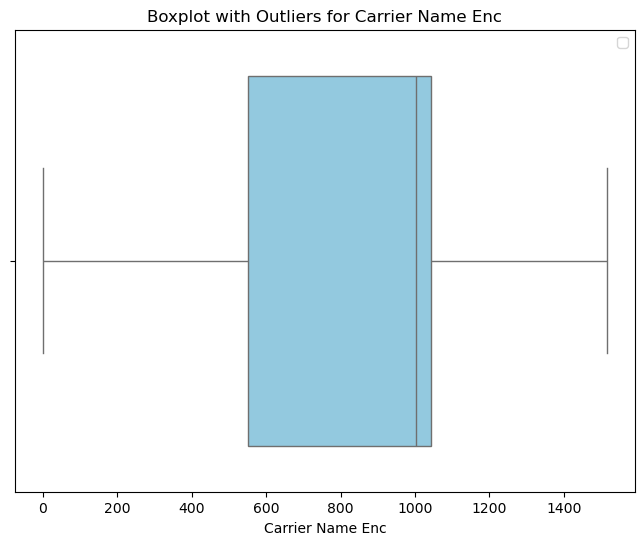

Column: Carrier Type freq - Number of Outliers: 0
Column: Carrier Type freq - % of Outliers: 0.00% 



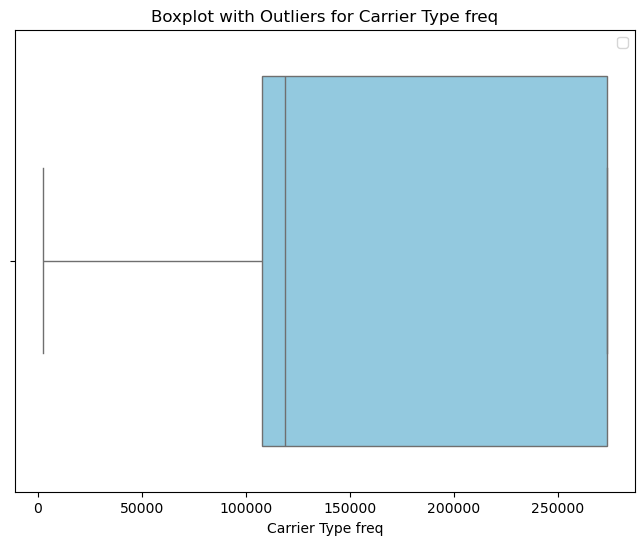

Column: Carrier Type_1A. PRIVATE - Number of Outliers: 0
Column: Carrier Type_1A. PRIVATE - % of Outliers: 0.00% 



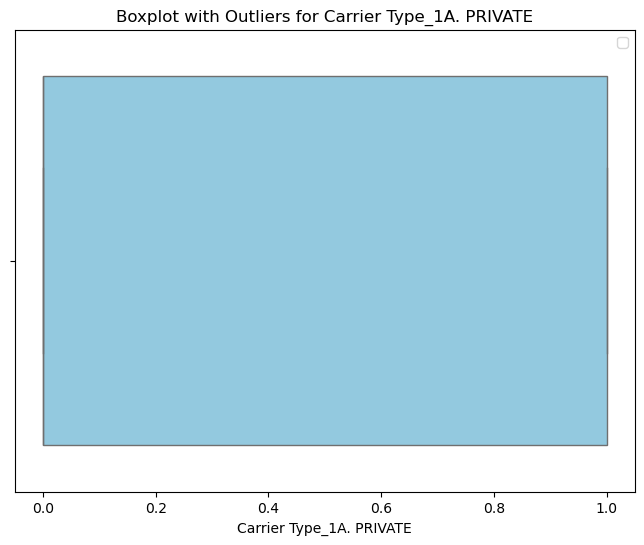

Column: Carrier Type_2A. SIF - Number of Outliers: 86030
Column: Carrier Type_2A. SIF - % of Outliers: 19.42% 



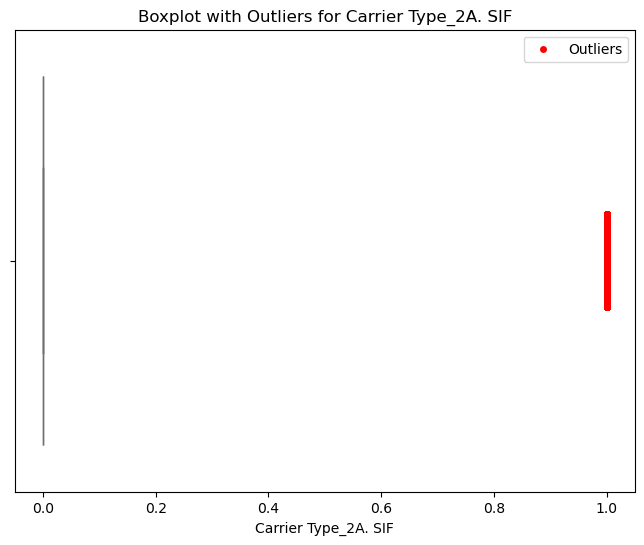

Column: Carrier Type_3A. SELF PUBLIC - Number of Outliers: 95183
Column: Carrier Type_3A. SELF PUBLIC - % of Outliers: 21.49% 



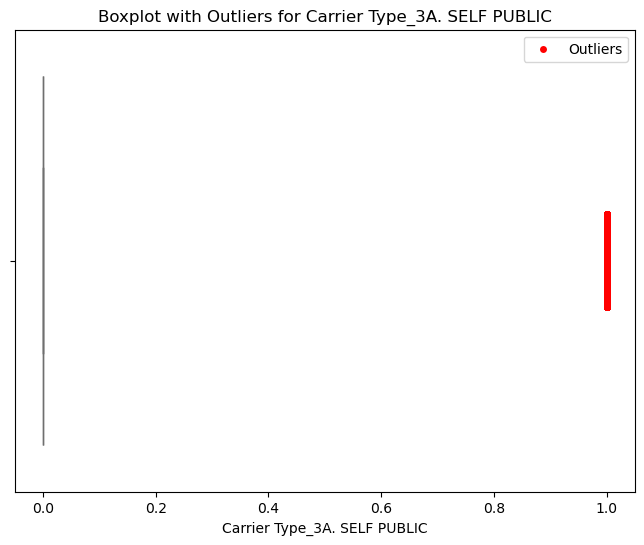

Column: Carrier Type_4A. SELF PRIVATE - Number of Outliers: 40840
Column: Carrier Type_4A. SELF PRIVATE - % of Outliers: 9.22% 



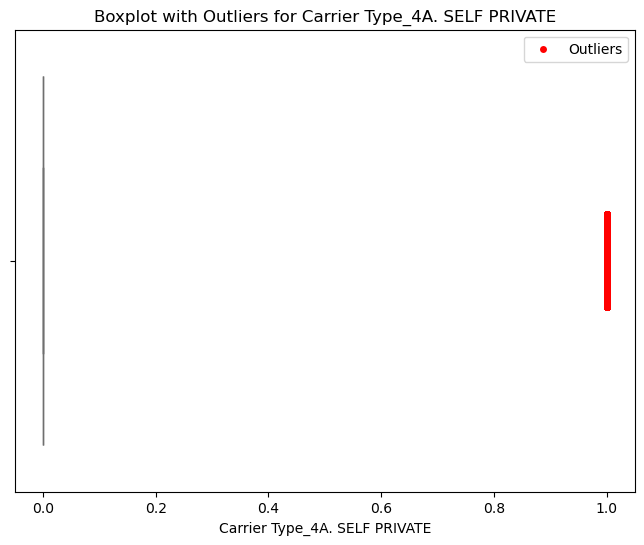

Column: County of Injury freq - Number of Outliers: 0
Column: County of Injury freq - % of Outliers: 0.00% 



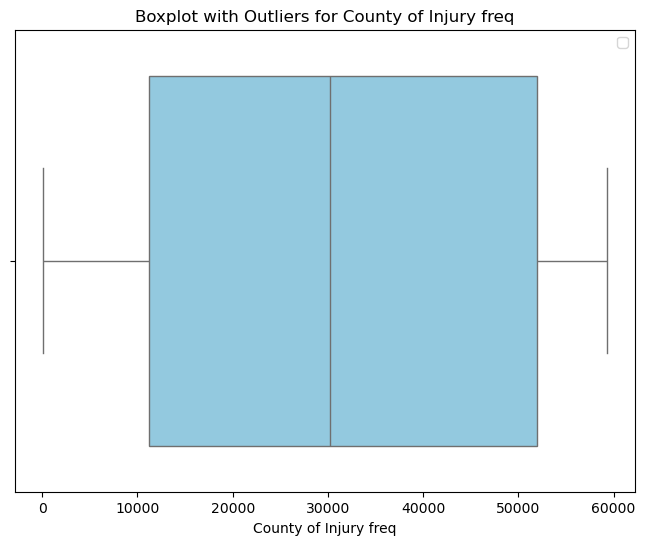

Column: COVID-19 Indicator Enc - Number of Outliers: 21038
Column: COVID-19 Indicator Enc - % of Outliers: 4.75% 



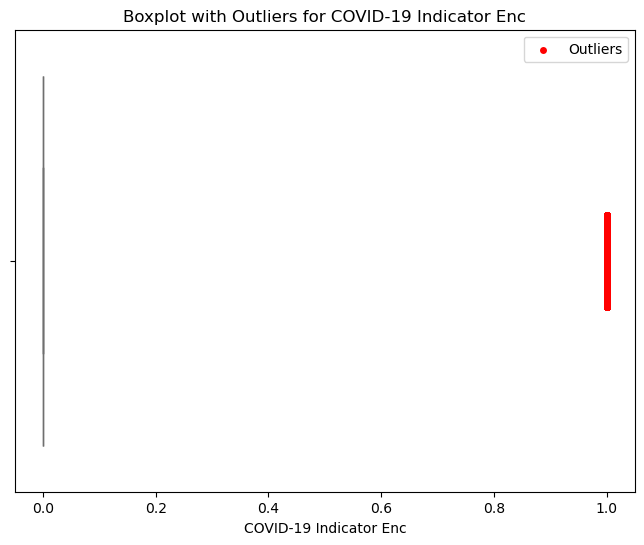

Column: District Name freq - Number of Outliers: 0
Column: District Name freq - % of Outliers: 0.00% 



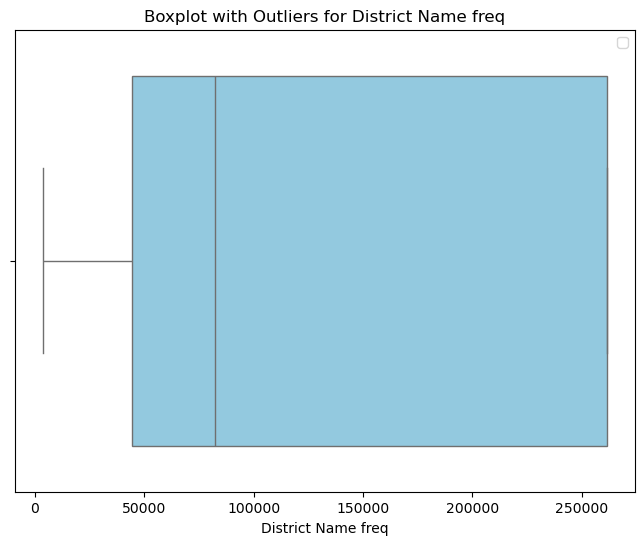

Column: Gender Enc - Number of Outliers: 0
Column: Gender Enc - % of Outliers: 0.00% 



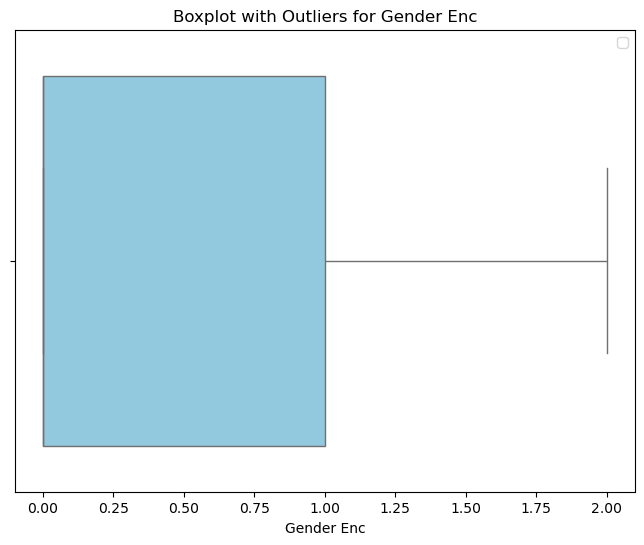

Column: Gender_F - Number of Outliers: 0
Column: Gender_F - % of Outliers: 0.00% 



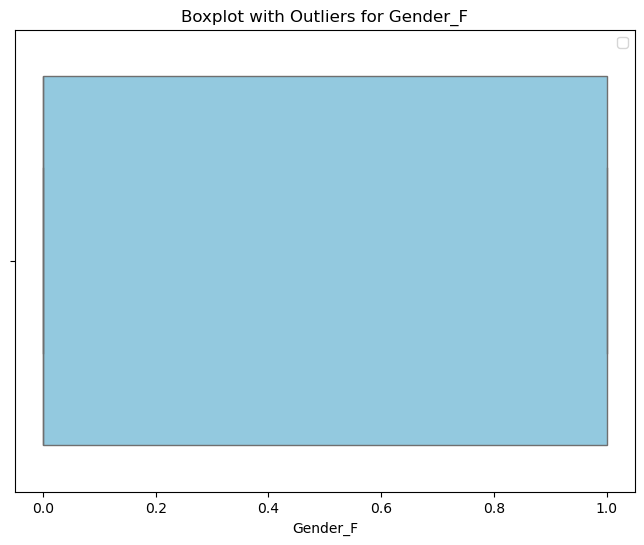

Column: Gender_M - Number of Outliers: 0
Column: Gender_M - % of Outliers: 0.00% 



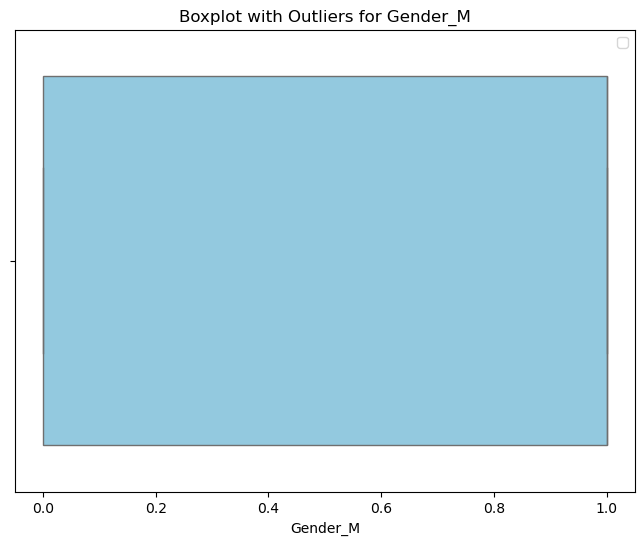

Column: Medical Fee Region freq - Number of Outliers: 0
Column: Medical Fee Region freq - % of Outliers: 0.00% 



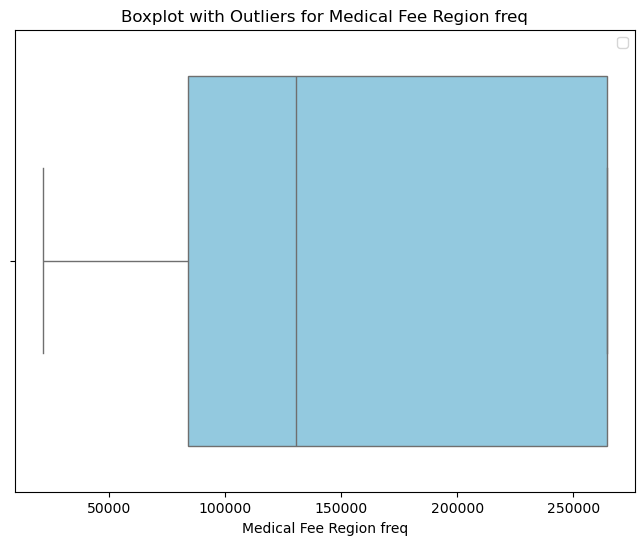

Column: Accident Date Year - Number of Outliers: 3494
Column: Accident Date Year - % of Outliers: 0.79% 



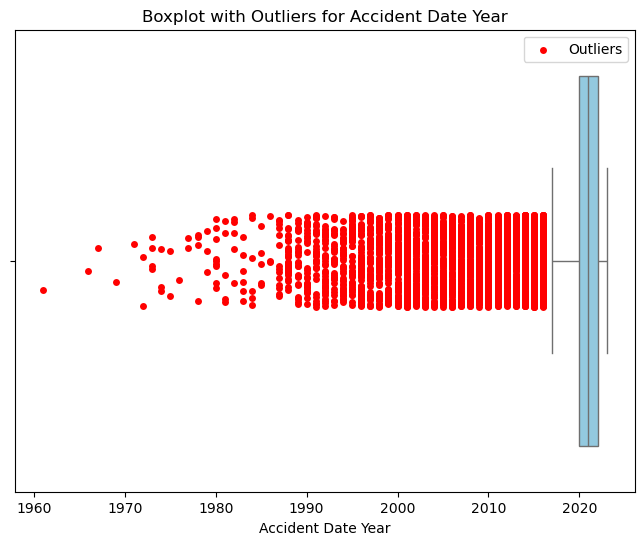

Column: Accident Date Month - Number of Outliers: 0
Column: Accident Date Month - % of Outliers: 0.00% 



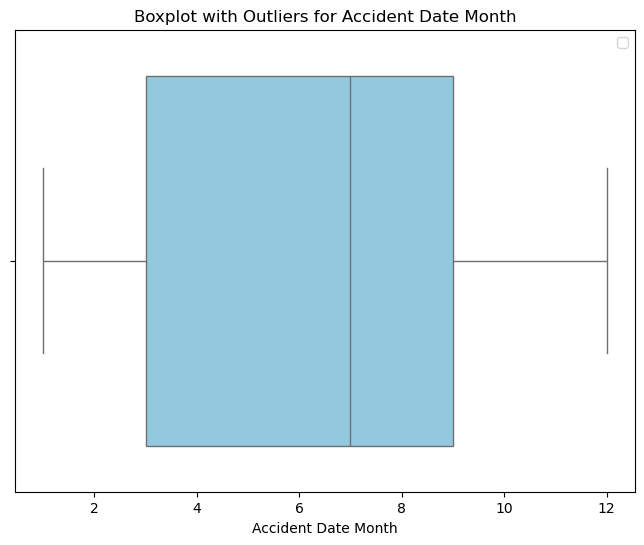

Column: Accident Date Day - Number of Outliers: 0
Column: Accident Date Day - % of Outliers: 0.00% 



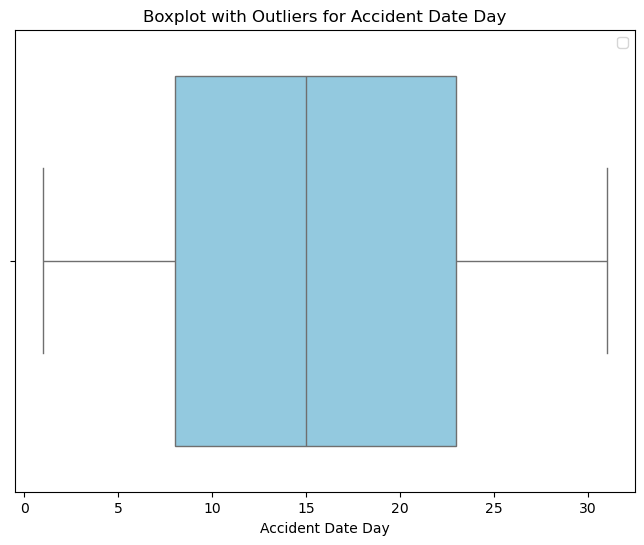

Column: Accident Date Day of Week - Number of Outliers: 0
Column: Accident Date Day of Week - % of Outliers: 0.00% 



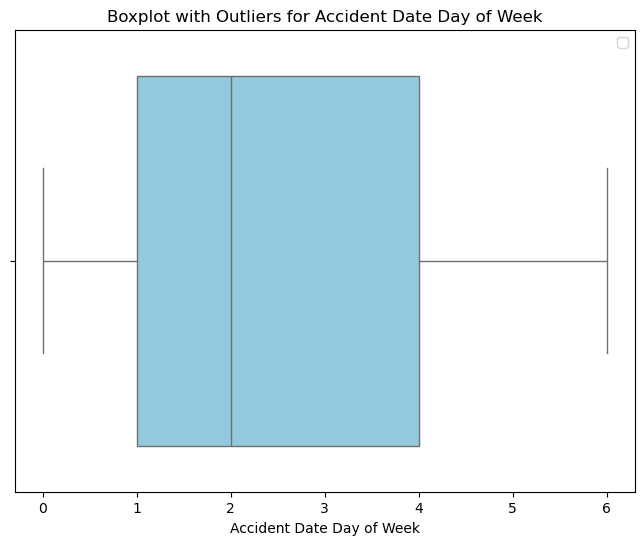

Column: Assembly Date Year - Number of Outliers: 0
Column: Assembly Date Year - % of Outliers: 0.00% 



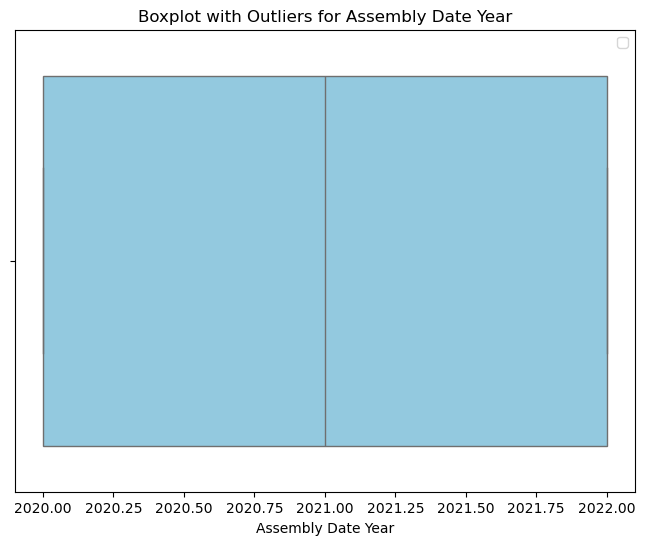

Column: Assembly Date Month - Number of Outliers: 0
Column: Assembly Date Month - % of Outliers: 0.00% 



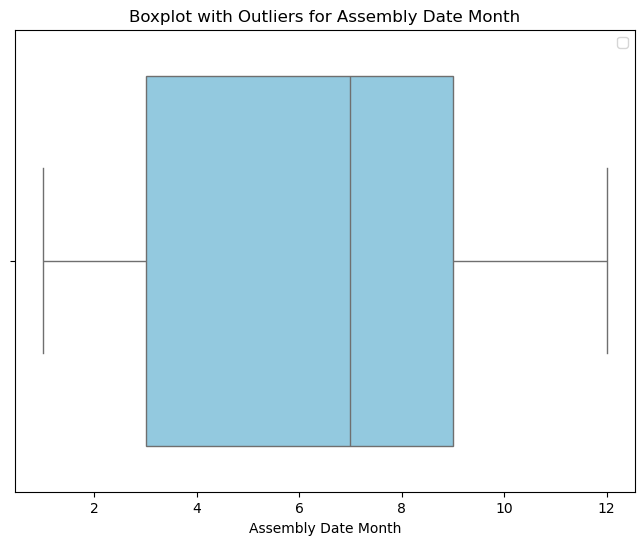

Column: Assembly Date Day - Number of Outliers: 0
Column: Assembly Date Day - % of Outliers: 0.00% 



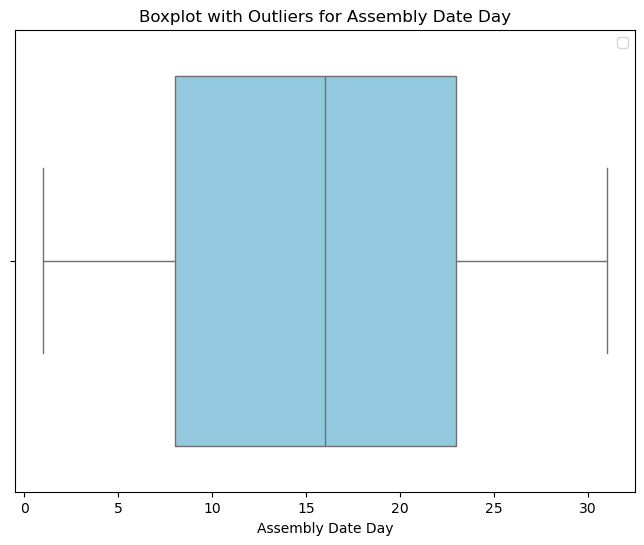

Column: Assembly Date Day of Week - Number of Outliers: 0
Column: Assembly Date Day of Week - % of Outliers: 0.00% 



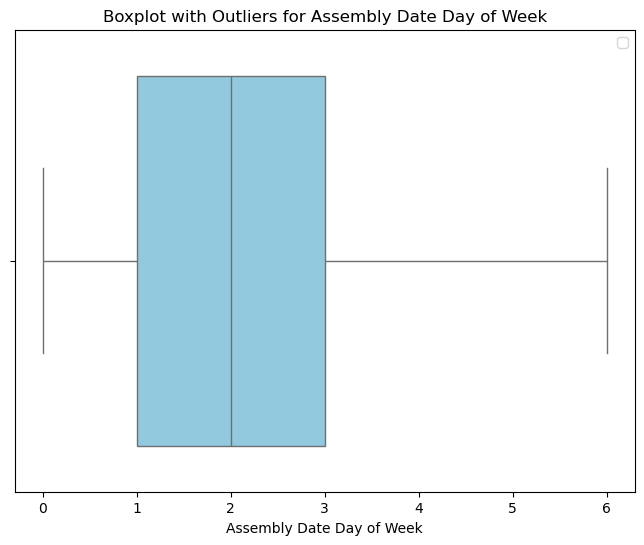

Column: C-2 Date Year - Number of Outliers: 883
Column: C-2 Date Year - % of Outliers: 0.20% 



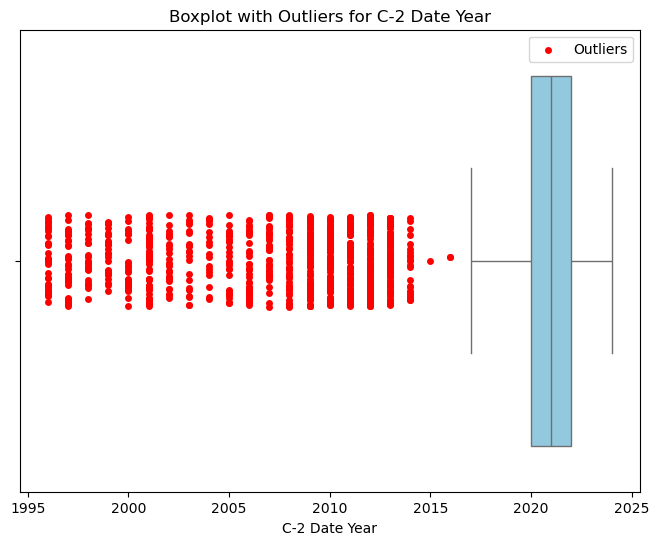

Column: C-2 Date Month - Number of Outliers: 0
Column: C-2 Date Month - % of Outliers: 0.00% 



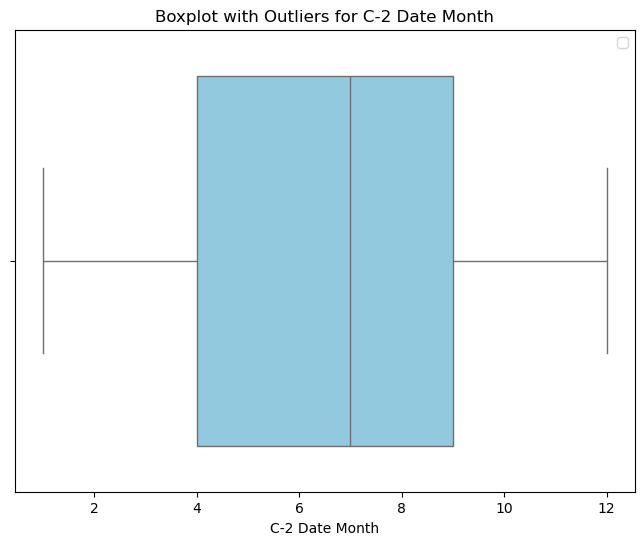

Column: C-2 Date Day - Number of Outliers: 0
Column: C-2 Date Day - % of Outliers: 0.00% 



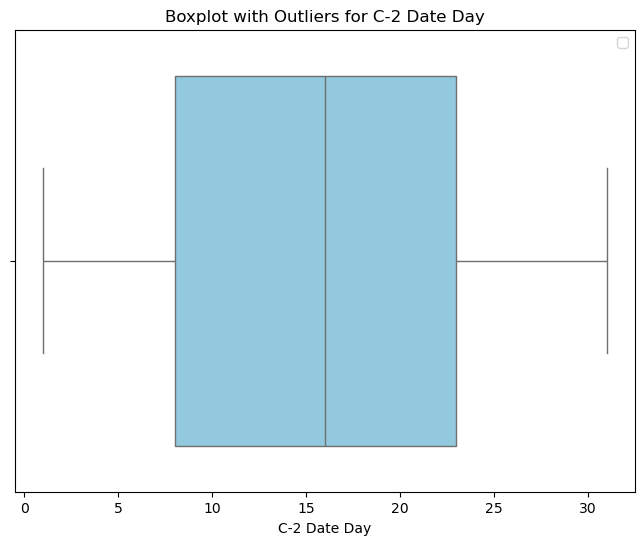

Column: C-2 Date Day of Week - Number of Outliers: 0
Column: C-2 Date Day of Week - % of Outliers: 0.00% 



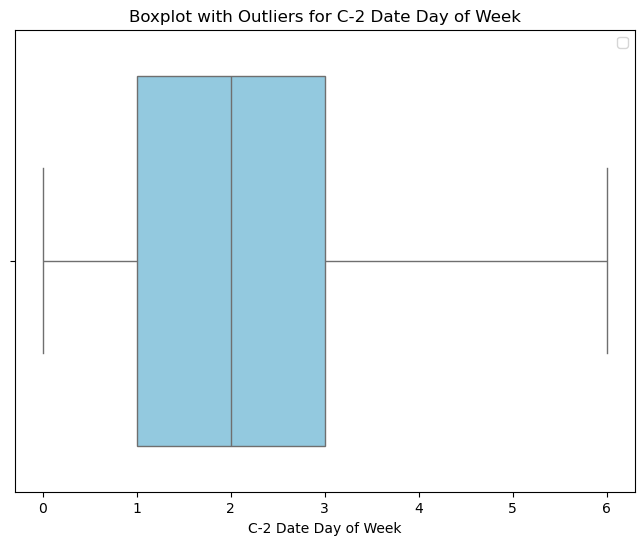

Column: WCIO Codes - Number of Outliers: 0
Column: WCIO Codes - % of Outliers: 0.00% 



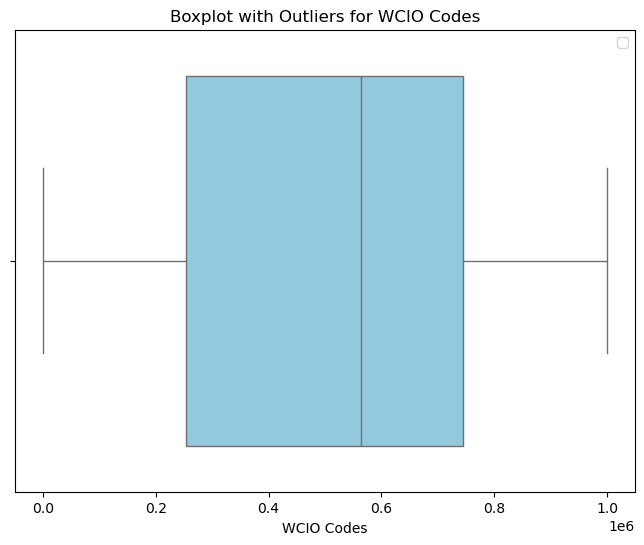

Column: Zip Code Valid - Number of Outliers: 33907
Column: Zip Code Valid - % of Outliers: 7.66% 



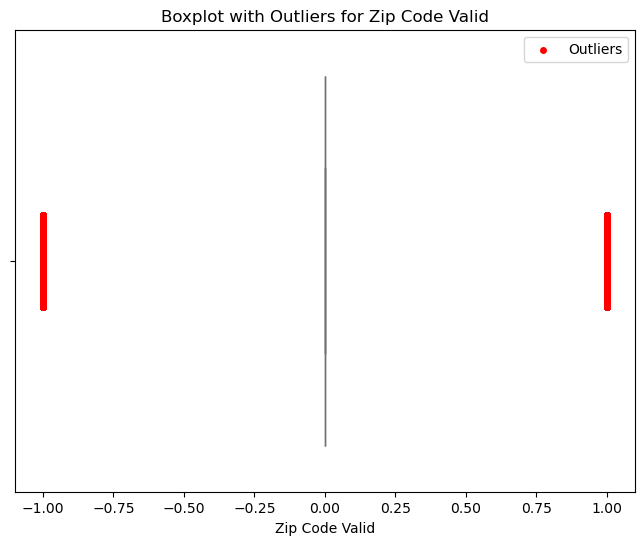

Column: Industry Sector Count Enc - Number of Outliers: 0
Column: Industry Sector Count Enc - % of Outliers: 0.00% 



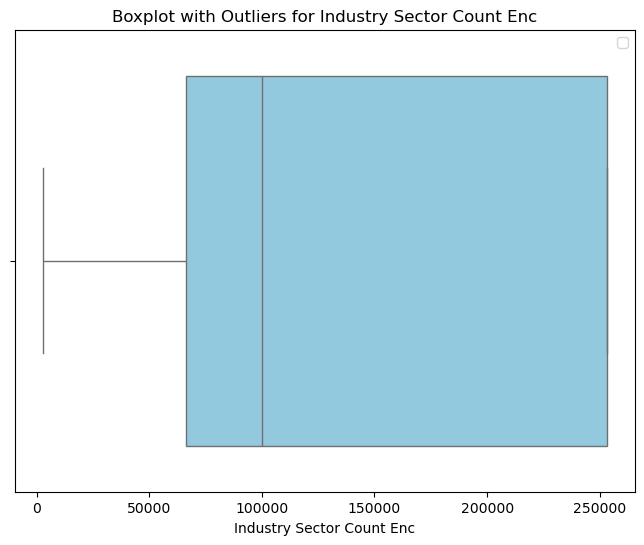

Column: Age Group - Number of Outliers: 23820
Column: Age Group - % of Outliers: 5.38% 



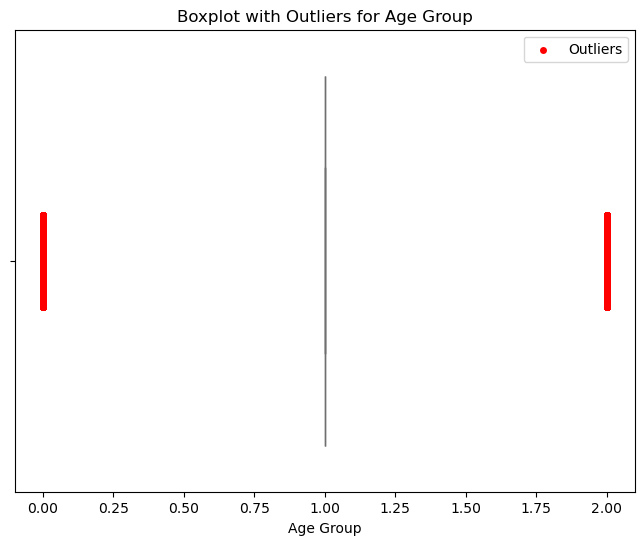

Column: C-3 Date Binary - Number of Outliers: 0
Column: C-3 Date Binary - % of Outliers: 0.00% 



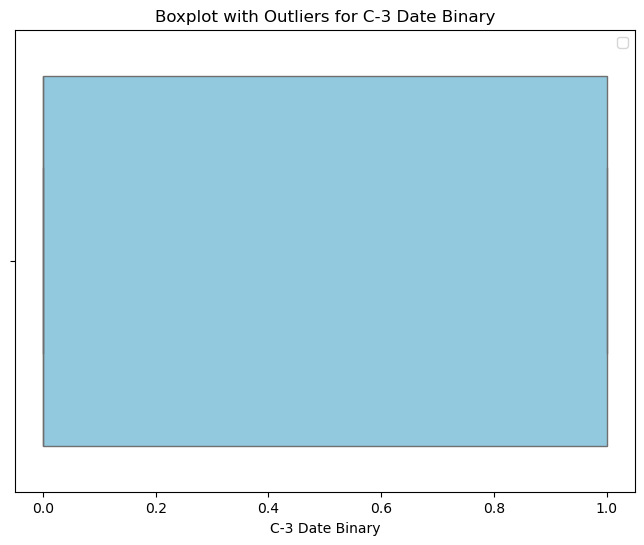

Column: First Hearing Date Binary - Number of Outliers: 0
Column: First Hearing Date Binary - % of Outliers: 0.00% 



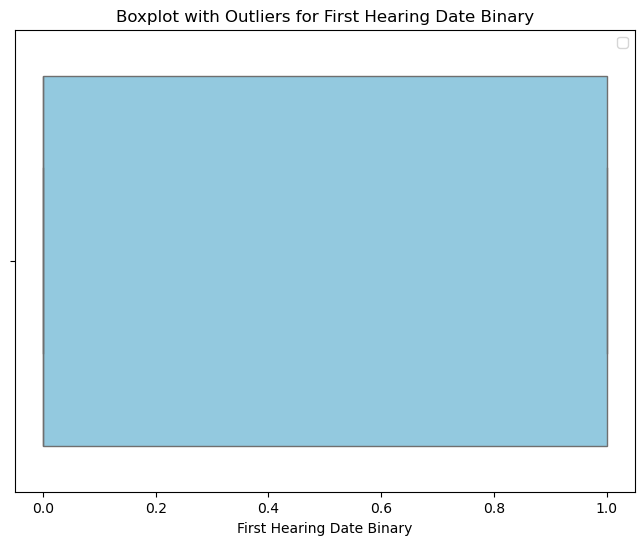

Columns with more than 0.0001% Outliers:
['Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Industry Code', 'WCIO Part Of Body Code', 'Alternative Dispute Resolution Bin', 'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC', 'Carrier Type_4A. SELF PRIVATE', 'COVID-19 Indicator Enc', 'Accident Date Year', 'C-2 Date Year', 'Zip Code Valid', 'Age Group']


{'Age at Injury': {'lower_bound': -3.5, 'upper_bound': 88.5},
 'Average Weekly Wage': {'lower_bound': -1240.24875,
  'upper_bound': 2067.08125},
 'Birth Year': {'lower_bound': 1932.5, 'upper_bound': 2024.5},
 'IME-4 Count': {'lower_bound': 0.0, 'upper_bound': 0.0},
 'Industry Code': {'lower_bound': 17.0, 'upper_bound': 89.0},
 'WCIO Cause of Injury Code': {'lower_bound': -40.0, 'upper_bound': 144.0},
 'WCIO Nature of Injury Code': {'lower_bound': -53.0, 'upper_bound': 115.0},
 'WCIO Part Of Body Code': {'lower_bound': 0.5, 'upper_bound': 84.5},
 'Number of Dependents': {'lower_bound': -5.0, 'upper_bound': 11.0},
 'Alternative Dispute Resolution Bin': {'lower_bound': 0.0,
  'upper_bound': 0.0},
 'Attorney/Representative Bin': {'lower_bound': -1.5, 'upper_bound': 2.5},
 'Carrier Name Enc': {'lower_bound': -189.5, 'upper_bound': 1782.5},
 'Carrier Type freq': {'lower_bound': -140960.5, 'upper_bound': 522051.5},
 'Carrier Type_1A. PRIVATE': {'lower_bound': -1.5, 'upper_bound': 2.5},
 'Carr

In [25]:
p.detect_outliers_iqr(X_train, 0.0001)

### Dealing With Outliers

Here we will apply some techniques to attempt to deal with outliers, either by applying some transformations or removing them. Our goal is to not remove more than 5% of observations. To keep track of this metrics, we will start by saving the initial length of the dataset.

In [73]:
X_train_copy = X_train.copy()
X_train_len = len(X_train_copy)

**Average Weekly Wage**

In [74]:
dropped_len_wage = len(X_train[X_train['Average Weekly Wage'] > 7300])

X_train = X_train[X_train['Average Weekly Wage'] <= 7300]

**Birth Year**

In [75]:
dropped_len_birth_year = len(X_train[X_train['Birth Year'] < 1932.5])

X_train = X_train[X_train['Birth Year'] > 1932.5]

**IME-4 Count**

In [76]:
X_train['IME-4 Count Log'] = np.log1p(X_train['IME-4 Count'])
X_train['IME-4 Count Double Log'] = np.log1p(X_train['IME-4 Count Log'])

**Alternative Dispute Resolution Bin**

In [77]:
dropped_len_alt_disp = len(X_train[X_train['Alternative Dispute Resolution Bin'] == 1])

X_train = X_train[X_train['Alternative Dispute Resolution Bin'] == 0]

**Covid-19 Indicator Enc**

In [78]:
X_train[X_train['COVID-19 Indicator Enc'] == 1]

Age at Injury  Average Weekly Wage  Birth Year  IME-4 Count  \
Claim Identifier                                                                
5640931                    65.0                 0.00      1955.0          0.0   
5480670                    35.0                 0.00      1985.0          0.0   
5877838                    57.0                 0.00      1964.0          0.0   
5791871                    42.0                 0.00      1978.0          0.0   
5618799                    29.0              1499.86      1990.0          0.0   
...                         ...                  ...         ...          ...   
5820967                    32.0                 0.00      1988.0          0.0   
5943011                    27.0                 0.00      1994.0          0.0   
5459803                    28.0                 0.00      1991.0          0.0   
5964282                    50.0              3035.97      1971.0          0.0   
5490075                    49.0              1680.91      1970.0          0.0   

                  Industry Code  WCIO Cause of Injury Code  \
Claim Identifier                                             
5640931                    62.0                         83   
5480670                    62.0                         83   
5877838                    92.0                         83   
5791871                    92.0                         83   
5618799                    62.0                         83   
...                         ...                        ...   
5820967                    92.0                         83   
5943011                    62.0                         83   
5459803                    44.0                         83   
5964282                    92.0                         83   
5490075                    62.0                         83   

                  WCIO Nature of Injury Code  WCIO Part Of Body Code  \
Claim Identifier                                                       
5640931                                   83                      99   
5480670                                   83                      60   
5877838                                   83                      91   
5791871                                   83                      91   
5618799                                   83                      60   
...                                      ...                     ...   
5820967                                   83                      60   
5943011                                   83                      91   
5459803                                   83                      66   
5964282                                   83                      60   
5490075                                   83                      91   

                  Number of Dependents  Alternative Dispute Resolution Bin  \
Claim Identifier                                                             
5640931                            2.0                                   0   
5480670                            3.0                                   0   
5877838                            2.0                                   0   
5791871                            3.0                                   0   
5618799                            4.0                                   0   
...                                ...                                 ...   
5820967                            2.0                                   0   
5943011                            0.0                                   0   
5459803                            2.0                                   0   
5964282                            5.0                                   0   
5490075                            1.0                                   0   

                  Attorney/Representative Bin  Carrier Name Enc  \
Claim Identifier                                                  
5640931                                     0              1495   
5480

**Accident Date Year**

In [79]:
dropped_len_accident_year =len(X_train[X_train['Accident Date Year'] < 2017])

X_train = X_train[X_train['Accident Date Year'] >= 2017]

**C-2 Date Year**

In [80]:
dropped_len_c2_year =len(X_train[X_train['C-2 Date Year'] < 2017])

X_train = X_train[X_train['C-2 Date Year'] >= 2017]

**Assess Decisions**

Since we dropped less than 5% of observations, we can continue to feature selection

In [83]:
len_dropped = dropped_len_wage + dropped_len_birth_year + dropped_len_alt_disp + dropped_len_accident_year + dropped_len_c2_year 

len_dropped / X_train_len

0.01269732326698696

# 4. Feature Selection

In this section we will perform feature selection. We will start by splitting data into numeric, categorical or max 3 classes. Then, scaling will be applied. However, from the previous delivery we noted that the best performing models are Tree-Based, which are not sensitive to feature's scale, and therefore do not require scaling. Consequently, we will implement the same method for both scaled and unscaled numerical data, and compare the results.

**Variable type split**

In [ ]:
num = []

max3_class = []

categ = []

**Scaling**

In [ ]:
robust = RobustScaler()

In [ ]:
# Scaling the numerical features in the training set using RobustScaler
X_train_num_RS = robust.fit_transform(X_train[num])
X_train_num_RS = pd.DataFrame(X_train_num_RS, columns=num, index=X_train.index)

In [ ]:
# Scaling the numerical features in the validation set using the fitted RobustScaler
X_val_num_RS = robust.transform(X_val[num])
X_val_num_RS = pd.DataFrame(X_val_num_RS, columns=num, index=X_val.index)

# Scaling the numerical features in the test set using the same fitted RobustScaler
test_num_RS = robust.transform(test[num])
test_num_RS = pd.DataFrame(test_num_RS, columns=num, index=test.index)

## 4.1 Filter-Based Methods
Filter-based methods evaluate the relevance of features independently of the model using statistical measures like correlation, Chi-square tests, and mutual information. This section explores how these methods help reduce dimensionality, improve model performance, and prevent overfitting by selecting the most informative features.

<a href="#top">Top &#129033;</a>

## 4.2 Wrapper Methods
Unlike filter methods, which assess features independently, wrapper methods evaluate the effectiveness of feature subsets by measuring the model’s performance, making them more computationally expensive but often more accurate in selecting relevant features.

<a href="#top">Top &#129033;</a>

## 4.3 Embedded Methods

These methods use algorithms that inherently select features as part of the model’s learning process. Embedded methods are computationally efficient and tend to be more accurate than filter methods, as they consider feature interactions and model performance simultaneously.

<a href="#top">Top &#129033;</a>